### Ship sailing strategies with various combinations of payloads and velocities for passing a bottleneck waterway section

### Steps before sailing: 
- Giving a sailing route, in which there is an section with limited water depth (h_min)
- Listing a group of possible actual draughts depending on the limited water depth and minimum operating draughts
- Using the T2v function to find out the corresponding velocities the ship can sail with to safely pass the bottlenek without grounding
- Displaying the possible actual draughts with its maximum sailing velocities and suggesting several sailing strategies.

### Steps while sailing: 
- c

### Test the reality of sailing with v_computed
We test it by comparing the total required power (P_tot) of the ship while sailing at v_computed with its installed power (P_installed). If P_tot <= P_installed, the v_computed is realistic.

So the steps to do:
- set the above results [Strategies: 'T_strategy','v_computed'] as input data for a vessel sailing and consuming energy simulation
- run the simulation to get results: 'P_tot', 'P_installed', 'total fuel use', 'total emissions_CO2', 'total emissions_PM10', 'total emissions_NOx', 'duration', 'payload'. (Note that you need the "T2payload" function based on "Van Dorsser's method" to get the corresponding 'payload'for each 'T_strategy'.) 
- put the results into dataframe for later easy selecting, processing and plotting
- select the Strategies of which P_tot <= P_installed 
- analysis the selected Strategies 
- visualize some typical selected Strategies via a series Bar Chart. In each bar chart, y_axis is amount, x_axis is evaluation items.
- visualize some typical selected Strategies together with ambient waterway sections of different water depths.(Note that the input [Vs, P_tot_given] are different for bottle neck section and ambient sections)

In [1]:
import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# OpenTNSim
import opentnsim
import opentnsim.strategy
# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')



### Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).

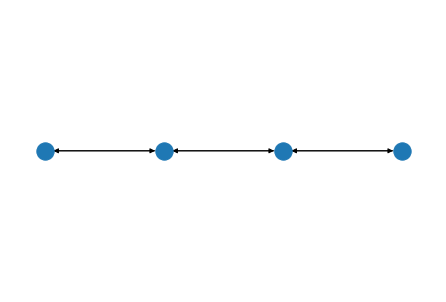

In [2]:
FG = nx.DiGraph()
nodes = []
path = []

Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

data_node_1 = {"name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_2 = {"name": "Node 2",
               "geometry": shapely.geometry.Point(0.8983, 0)}  # 0.8983 degree =100km
data_node_3 = {"name": "Node 3",
               "geometry": shapely.geometry.Point(1.7966, 0)}   # 1.7966 degree =200km
data_node_4 = {"name": "Node 4",
               "geometry": shapely.geometry.Point(2.6949, 0)}    # 2.6949 degree =300km

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2], # From node 1 to node 2
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3], # From node 4 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_2, node_1]] # From node 2 to node 1


for edge in path:
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": 6})
    
middle_edges = [
    (node_2.name, node_3.name),
    (node_3.name, node_2.name)
]
for e in middle_edges:
    edge = FG.edges[e]
    edge['Info']['GeneralDepth'] = 2.5

# env.FG = FG
nx.draw(FG, positions)
plt.show()

In [3]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 1', 'Node 2') is 6
General depth for edge ('Node 2', 'Node 3') is 2.5
General depth for edge ('Node 2', 'Node 1') is 6
General depth for edge ('Node 3', 'Node 4') is 6
General depth for edge ('Node 3', 'Node 2') is 2.5
General depth for edge ('Node 4', 'Node 3') is 6


### Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption.  

In [4]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
        
    ),
    {},
)  # needed to calculate resistances

In [5]:
# Create a dict with all important settings
data_vessel = {
               "env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": 1,  # m/s
               "type": 'Dortmund-Eems (L <= 74 m)', # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": None,
               "safety_margin": 0.2, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat":True,
               "P_installed": 1750.0,   
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to none; otherwise set to 1.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }          

### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [6]:
path = nx.dijkstra_path(FG, node_1.name, node_4.name)
path_bottleneck = nx.dijkstra_path(FG, node_2.name, node_3.name)

### Define T2v function

### Define P2v function

### Define formulate_sailing_strategies (T2v, P2v) simulation to get maximum possible veolicities
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [7]:
#formulate_sailing_strategies = opentnsim.strategy.get_v_max_for_bottleneck(FG, path, vessel, T_strategy) 

### Define T2Payload function to know the corresponding Payload for each T_strategy

### Define max_sinkage_at_v_strategy function to know the maximum sinkage for a possible velocity 

In [8]:
# with this function we can get differet max_sinkages for different velocities for one T_strategy or a list of T_strategy 
def max_sinkage_at_v_strategy (self, T_strategy, v_strategy):
        # Start simpy environment
        
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG
            
    # create a fresh instance of vessel
#    print('start the vessel')
    vessel = TransportResource(**data_vessel)
    vessel.name = 'Vessel No.1'                     
    # add environment and path to the vessel
    vessel.env = env                                        #the created environment
    vessel.route = path_bottleneck  
    # position vessel at the start of the path
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)

    
    max_sinkage = (vessel.C_B * ((vessel.B * T_strategy) / (150 * vessel.h_min)) ** 0.81) * ((v_strategy*1.94) ** 2.08) / 20
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return v_strategy, max_sinkage

### Prepare input matrix for 'formulate_sailing_strategies simulation (T2v, P2v)'

In [19]:
# give some possible draught for h_min = 2.5 m
# TODO: give T_strategy for passing limited water depth by collectting values between min-operational draught and (h_min-ukc)
#T_strategy = [2,1.99,1.98,1.97,1.96,1.95, 1.94,1.93,1.92,1.9,1.8,1.7,1.6,1.5] 
T_strategy = [2.27,2.2,2.15,2.1,2.07,2.05,2.03,2,1.99,1.98,1.97,1.96,1.95, 1.94,1.93,1.92,1.9,1.8,1.7,1.6,1.5] 
h_min = [2.5]
safety_margin =[0.2]

In [20]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(T_strategy, h_min, safety_margin))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T_strategy": item[0],"h_min":item[1], "safety_margin":item[2]}
    rows.append(row)

    # these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,T_strategy,h_min,safety_margin
16,1.9,2.5,0.2
17,1.8,2.5,0.2
18,1.7,2.5,0.2
19,1.6,2.5,0.2
20,1.5,2.5,0.2


### Run 'formulate_sailing_strategies simulation' to get maximum possible sailing veolicites for the T_strategy for h_min with a safety margin

In [21]:
Strategies = []
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = FG
    
for i, row in tqdm.tqdm(work_df.iterrows()):
    T_strategy = row['T_strategy']
    h_min = row['h_min']
    safety_margin = row['safety_margin']
    
   
    vessel = TransportResource(**data_vessel)
    vessel.name = 'Vessel No.1'                     
    # add environment and path to the vessel
    vessel.env = env                                        #the created environment
    vessel.route = path_bottleneck  
    # position vessel at the start of the path
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel._T = T_strategy

    v_T2v, v_P2v, v_max_final = opentnsim.strategy.get_v_max_for_bottleneck(FG, path_bottleneck, vessel, T_strategy)
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, T_strategy, vessel_type = "Tanker") 
    
    v_strategy, max_sinkage = max_sinkage_at_v_strategy (vessel,T_strategy, v_max_final)
    remained_distance_to_margin = h_min - T_strategy - max_sinkage - safety_margin
    
    
    
    Strategy ={}
    Strategy.update(row)
    Strategy['max_sinkage_at_v_max_final (cm)'] = max_sinkage * 100    
    Strategy['h_min'] = h_min
    Strategy['safety_margin'] = safety_margin
    Strategy['remained_distance_to_margin (cm)'] = remained_distance_to_margin * 100
    Strategy['v_max_(sinkage_allowed) (m/s)'] = v_T2v
    Strategy['v_max_(power_allowed) (m/s)'] = v_P2v    
    Strategy['v_max_final (m/s)'] = v_max_final
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted
    Strategies.append(Strategy)
    

0it [00:00, ?it/s]Exception ignored in: <function BaseGeometry.__del__ at 0x0000012D418F8F70>
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x0000012D418F8F70>
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x0000012D418F8F70>
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x0000012D418F8F70>
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x0000012D418F8F70>
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x0000012D418F8F70>
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x0000012D418F8F70>
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x0000012D418F8F70>
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x0000012D418F8F70>
AttributeE

### The DataFrame Table (Strategies_df) showing below is the overall strategy for an M8 tanker vessel to pass the bottleneck section (h_min = 2.5 m, safety margin = 0.3 m), including:
- possible draughts, corresponding payloads,
- maximum ship velocities considering maximum allowed sinkage without touching safety margin,
- maximum ship velocities within installed power, 
- the final realistic maximum ship velocities (v_max_final) considering both maximum allowed sinkage and installed power (which is the lower value between v_max(sinkage_allowed) and v_max_(power_allowed) )    
- remained_distance between ship bottom to safety margin while sailing at v_max_final with its maximum sinkage 

In [22]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(Strategies_df)

,T_strategy,h_min,safety_margin,max_sinkage_at_v_max_final (cm),remained_distance_to_margin (cm),v_max_(sinkage_allowed) (m/s),v_max_(power_allowed) (m/s),v_max_final (m/s),Payload_strategy_tanker (ton)
0,2.2700,2.5000,0.2000,3.0000,0.0000,1.2349,3.1669,1.2349,1307.5472
1,2.2000,2.5000,0.2000,10.0000,0.0000,2.2300,3.5577,2.2300,1227.2542
2,2.1500,2.5000,0.2000,15.0000,0.0000,2.7344,3.7160,2.7344,1169.9783
3,2.1000,2.5000,0.2000,20.0000,0.0000,3.1689,3.7470,3.1689,1112.7661
4,2.0700,2.5000,0.2000,23.0000,-0.0000,3.4082,3.7544,3.4082,1078.4692
5,2.0500,2.5000,0.2000,25.0000,-0.0000,3.5610,3.7578,3.5610,1055.6174
6,2.0300,2.5000,0.2000,27.0000,0.0000,3.7094,3.7604,3.7094,1032.7757
7,2.0000,2.5000,0.2000,27.4873,2.5127,3.9248,3.7632,3.7632,998.5323
8,1.9900,2.5000,0.2000,27.3872,3.6128,3.9950,3.7639,3.7639,987.1229
9,1.9800,2.5000,0.2000,27.2855,4.7145,4.0644,3.7646,3.7646,975.7161


### Based on the overall strategies from the above table, we do a further analysis for one given T_strategy with several possible velocities 

In [ ]:
T_strategy_n10 = [2.1] 
v_strategy_n10 = [0, 1, 1.5, 2, 2.5, 3, 3.5, 3.91]
h_min = [2.5]

safety_margin =[0.3]

In [ ]:
# prepare the work to be done
# create a list of all combinations
work4 = list(itertools.product(T_strategy_n10, v_strategy_n10, h_min, safety_margin))

# prepare a list of dictionaries for pandas
rows4 = []
for item4 in work4:
    row4 = {"T_strategy_n10 (m)": item4[0], "v_strategy_n10 (m/s)": item4[1], "h_min":item4[2], "safety_margin":item4[3]}
    rows4.append(row4)
print(row4)
# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work4_df = pd.DataFrame(rows4)
work4_df.tail(8)

In [ ]:
Strategies_n10 = []

for i, row4 in tqdm.tqdm(work4_df.iterrows()):
    T_strategy_n10 = row4['T_strategy_n10 (m)']
    v_strategy_n10 = row4['v_strategy_n10 (m/s)']
    h_min_n10 = row4['h_min']
    safety_margin_n10 = row4['safety_margin']
    
   
    vessel = TransportResource(**data_vessel)
    vessel._T = T_strategy
    
    Payload_strategy_n10 = T2Payload(vessel, T_strategy_n10, vessel_type = "Tanker") 
    
    v_strategy_n10, max_sinkage_n10 = max_sinkage_at_v_strategy (vessel,T_strategy_n10, v_strategy_n10)
    remained_distance_to_margin_n10 = h_min_n10 - T_strategy_n10 - max_sinkage_n10 - safety_margin_n10
    
    
    Strategy_n10 ={}
    Strategy_n10.update(row4)
        
    Strategy_n10['h_min'] = h_min_n10    
    Strategy_n10['max_sinkage_at_v_strategy (cm)'] = max_sinkage_n10 * 100
    Strategy_n10['remained_distance_to_margin (cm)'] = remained_distance_to_margin_n10 * 100
    Strategy_n10['safety_margin'] = safety_margin_n10
    Strategy_n10['Payload_strategy_tanker (ton)'] = Payload_strategy_n10
    Strategies_n10.append(Strategy_n10)
    

### The DataFrame Table (Strategies_n10_df) showing below is the strategy for an M8 tanker vessel to pass the bottleneck section (h_min = 2.5 m, safety margin = 0.3 m) with a given T_strategy = 2.1 m and a list of possible velocities, including:
- given draught, corresponding payload,
- maximum sinkage at each v_strategy
- remained_distance between ship bottom to safety margin while sailing at each given v_strategy

In [ ]:
Strategies_n10_df = pd.DataFrame(Strategies_n10)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(Strategies_n10_df)

### Based on the overall and detailed strategies analysis above, next we simulate the energy consumption and sailing duration for the selected strategies

- 1st we simulate for passing the bottleneck section (h_min = 2.5 m) with overall strategies (all the T_strategies with v_max_final) 
- 2nd we simulate for passing the bottleneck section (h_min = 2.5 m) with selected strategies
- 3rd we simulate for passing the whloe sections: (h_0: 6 m, 2.5 m, 6 m) with selected strategies
  - the selected strategies are: 
    - T_strategy = 2.1 m
    - v_strategy = [3, 3.5] m/s;   
    Note that for (h_0: 6 m, 4 m, 6 m) and (h_0: 6 m, 6 m, 6 m) examples, v_strategy = [3, 3.5, 4] m/s

### Define "T_v_strategy_energy_simulation" for passing bottleneck section (h_min = 2.5 m)

In [ ]:
def T_v_strategy_energy_simulation(v_strategy, T_strategy):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path               #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel._T = T_strategy
    vessel.v = v_strategy
    depths = []
    for e in zip(vessel.route[:-1], vessel.route[1:]):
        edge = env.FG.edges[e]
        depth = edge['Info']['GeneralDepth']
        depths.append(depth)
    # h_0 = min(depths)
    for depth in depths:
            h_0 = depth
            h_0 = vessel.calculate_h_squat(v = v_strategy, h_0 = h_0)
            print(h_0)

    # Start the simulation
    env.process(vessel.move())
    env.run()
    # print(depths)
    # print(h_0)
    return vessel

### Run "T_v_strategy_energy_simulation" for passing bottleneck section with overall strategies (all the T_strategies with v_max_final)

In [ ]:
# remove the row of "v_max_final = 0" from the input data, 
# otherwise, the "T_v_strategy_energy_simulation" function doesn't work
Strategies_overall_df = Strategies_df[1:25] 
#Strategies_overall_df

In [ ]:
df_overall_collect = {}
#sinkage_max = {}


for i, row in tqdm.tqdm(Strategies_overall_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)   
    
    v_max_final = row['v_max_final (m/s)']
    T_strategy = row['T_strategy']
    
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel = T_v_strategy_energy_simulation(v_max_final, T_strategy)

    #create an EnergyCalculation object and perform energy consumption calculation
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    #P_tot = vessel.calculate_total_power_required(v_computed)
    
    # create dataframe from energy calculation computation
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    df.update(row)
    
    # add/modify some comlums to suit our plotting needs
    # df['P_tot'] = P_tot
    df['fuel_kg_bottleneck'] = df['total_fuel_consumption']/1000   # g --> kg
    df['CO2_kg_bottleneck']   = df['total_emission_CO2']/1000
    df['PM10_kg_bottleneck']  = df['total_emission_PM10']/1000
    df['NOx_kg_bottleneck']   = df['total_emission_NOX']/1000
    df['duration_hrs_bottleneck'] = df['delta_t'] /3600  # s--> hour
    # df['sinkage_max_m_bottleneck'] = sinkage_max
    # df['Payload_strategy_ton_bottleneck'] = Payload_strategy
    
    
    label = 'T_strategy = ' + str(T_strategy) + ' v_max_final = ' + str(round(v_max_final,2))
    
    df_overall_collect[label + ' P_tot']   = list(df.P_tot[[0]])
    df_overall_collect[label + ' P_installed'] = list(df.P_installed[[0]])
    df_overall_collect[label + ' duration_hrs_bottleneck']   = list(df.duration_hrs_bottleneck[[0]])
    df_overall_collect[label + ' fuel_kg_bottleneck']   = list(df.fuel_kg_bottleneck[[0]])
    df_overall_collect[label + ' CO2_kg_bottleneck'] = list(df.CO2_kg_bottleneck[[0]])
    df_overall_collect[label + ' PM10_kg_bottleneck']   = list(df.PM10_kg_bottleneck[[0]])
    df_overall_collect[label + ' NOx_kg_bottleneck']   = list(df.NOx_kg_bottleneck[[0]])
    


In [ ]:
df_overall_collect

In [ ]:
df_overall_plot = pd.DataFrame( df_overall_collect )
df_overall_plot

In [ ]:
fuel=df_overall_plot[['T_strategy = 2.19 v_max_final = 1.43 fuel_kg_bottleneck',
              'T_strategy = 2.18 v_max_final = 2.0 fuel_kg_bottleneck',
              'T_strategy = 2.17 v_max_final = 2.44 fuel_kg_bottleneck', 
              'T_strategy = 2.16 v_max_final = 2.8 fuel_kg_bottleneck',
              'T_strategy = 2.15 v_max_final = 3.13 fuel_kg_bottleneck',
              'T_strategy = 2.14 v_max_final = 3.42 fuel_kg_bottleneck',
              'T_strategy = 2.13 v_max_final = 3.69 fuel_kg_bottleneck',
              'T_strategy = 2.12 v_max_final = 3.91 fuel_kg_bottleneck',
              'T_strategy = 2.11 v_max_final = 3.91 fuel_kg_bottleneck',
              'T_strategy = 2.1 v_max_final = 3.91 fuel_kg_bottleneck',
              'T_strategy = 2.05 v_max_final = 3.91 fuel_kg_bottleneck',
              'T_strategy = 2.0 v_max_final = 3.91 fuel_kg_bottleneck',
              'T_strategy = 1.95 v_max_final = 3.91 fuel_kg_bottleneck',
              'T_strategy = 1.9 v_max_final = 3.91 fuel_kg_bottleneck',                      
              'T_strategy = 1.85 v_max_final = 3.9 fuel_kg_bottleneck',
              'T_strategy = 1.8 v_max_final = 3.9 fuel_kg_bottleneck',
              'T_strategy = 1.75 v_max_final = 3.89 fuel_kg_bottleneck',
              'T_strategy = 1.7 v_max_final = 3.89 fuel_kg_bottleneck',
              'T_strategy = 1.65 v_max_final = 3.88 fuel_kg_bottleneck',   
              'T_strategy = 1.6 v_max_final = 3.87 fuel_kg_bottleneck',
              'T_strategy = 1.55 v_max_final = 3.86 fuel_kg_bottleneck',
              'T_strategy = 1.5 v_max_final = 3.84 fuel_kg_bottleneck',
              'T_strategy = 1.45 v_max_final = 3.8 fuel_kg_bottleneck',
              'T_strategy = 1.4 v_max_final = 4.04 fuel_kg_bottleneck',                       
               ]].T

fuel.index=[
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',                      
           ]

fuel.columns =['section 2 (bottleneck)']
fuel.head(24)

In [ ]:
fuel_colors=['#bf9005']
fuel.plot(kind='bar',stacked=True,color=fuel_colors,rot=0, figsize=(28, 5))

In [ ]:
CO2=df_overall_plot[[ 
              'T_strategy = 2.19 v_max_final = 1.43 CO2_kg_bottleneck',
              'T_strategy = 2.18 v_max_final = 2.0 CO2_kg_bottleneck',
              'T_strategy = 2.17 v_max_final = 2.44 CO2_kg_bottleneck', 
              'T_strategy = 2.16 v_max_final = 2.8 CO2_kg_bottleneck',
              'T_strategy = 2.15 v_max_final = 3.13 CO2_kg_bottleneck',
              'T_strategy = 2.14 v_max_final = 3.42 CO2_kg_bottleneck',
              'T_strategy = 2.13 v_max_final = 3.69 CO2_kg_bottleneck',
              'T_strategy = 2.12 v_max_final = 3.91 CO2_kg_bottleneck',
              'T_strategy = 2.11 v_max_final = 3.91 CO2_kg_bottleneck',
              'T_strategy = 2.1 v_max_final = 3.91 CO2_kg_bottleneck',
              'T_strategy = 2.05 v_max_final = 3.91 CO2_kg_bottleneck',
              'T_strategy = 2.0 v_max_final = 3.91 CO2_kg_bottleneck',
              'T_strategy = 1.95 v_max_final = 3.91 CO2_kg_bottleneck',
              'T_strategy = 1.9 v_max_final = 3.91 CO2_kg_bottleneck',                      
              'T_strategy = 1.85 v_max_final = 3.9 CO2_kg_bottleneck',
              'T_strategy = 1.8 v_max_final = 3.9 CO2_kg_bottleneck',
              'T_strategy = 1.75 v_max_final = 3.89 CO2_kg_bottleneck',
              'T_strategy = 1.7 v_max_final = 3.89 CO2_kg_bottleneck',
              'T_strategy = 1.65 v_max_final = 3.88 CO2_kg_bottleneck',   
              'T_strategy = 1.6 v_max_final = 3.87 CO2_kg_bottleneck',
              'T_strategy = 1.55 v_max_final = 3.86 CO2_kg_bottleneck',
              'T_strategy = 1.5 v_max_final = 3.84 CO2_kg_bottleneck',
              'T_strategy = 1.45 v_max_final = 3.8 CO2_kg_bottleneck',
              'T_strategy = 1.4 v_max_final = 4.04 CO2_kg_bottleneck',                                               
                    ]].T

CO2.index=[ 
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',      
            ]

CO2.columns =['section 2 (bottleneck)']
CO2.head(24)

In [ ]:
CO2_colors=['orange']
CO2.plot(kind='bar', stacked=True,color=CO2_colors,rot=0, figsize=(28, 5))

In [ ]:
PM10=df_overall_plot[[
              'T_strategy = 2.19 v_max_final = 1.43 PM10_kg_bottleneck',
              'T_strategy = 2.18 v_max_final = 2.0 PM10_kg_bottleneck',
              'T_strategy = 2.17 v_max_final = 2.44 PM10_kg_bottleneck', 
              'T_strategy = 2.16 v_max_final = 2.8 PM10_kg_bottleneck',
              'T_strategy = 2.15 v_max_final = 3.13 PM10_kg_bottleneck',
              'T_strategy = 2.14 v_max_final = 3.42 PM10_kg_bottleneck',
              'T_strategy = 2.13 v_max_final = 3.69 PM10_kg_bottleneck',
              'T_strategy = 2.12 v_max_final = 3.91 PM10_kg_bottleneck',
              'T_strategy = 2.11 v_max_final = 3.91 PM10_kg_bottleneck',
              'T_strategy = 2.1 v_max_final = 3.91 PM10_kg_bottleneck',
              'T_strategy = 2.05 v_max_final = 3.91 PM10_kg_bottleneck',
              'T_strategy = 2.0 v_max_final = 3.91 PM10_kg_bottleneck',
              'T_strategy = 1.95 v_max_final = 3.91 PM10_kg_bottleneck',
              'T_strategy = 1.9 v_max_final = 3.91 PM10_kg_bottleneck',                      
              'T_strategy = 1.85 v_max_final = 3.9 PM10_kg_bottleneck',
              'T_strategy = 1.8 v_max_final = 3.9 PM10_kg_bottleneck',
              'T_strategy = 1.75 v_max_final = 3.89 PM10_kg_bottleneck',
              'T_strategy = 1.7 v_max_final = 3.89 PM10_kg_bottleneck',
              'T_strategy = 1.65 v_max_final = 3.88 PM10_kg_bottleneck',   
              'T_strategy = 1.6 v_max_final = 3.87 PM10_kg_bottleneck',
              'T_strategy = 1.55 v_max_final = 3.86 PM10_kg_bottleneck',
              'T_strategy = 1.5 v_max_final = 3.84 PM10_kg_bottleneck',
              'T_strategy = 1.45 v_max_final = 3.8 PM10_kg_bottleneck',
              'T_strategy = 1.4 v_max_final = 4.04 PM10_kg_bottleneck',               
               ]].T

PM10.index=[
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s', 
            ]

PM10.columns =['section 2 (bottleneck)']
PM10.head(24)

In [ ]:
PM10_colors=['mediumseagreen']
PM10.plot(kind='bar', stacked=True,color=PM10_colors,rot=0, figsize=(26, 5))

In [ ]:
NOx=df_overall_plot[[
              'T_strategy = 2.19 v_max_final = 1.43 NOx_kg_bottleneck',
              'T_strategy = 2.18 v_max_final = 2.0 NOx_kg_bottleneck',
              'T_strategy = 2.17 v_max_final = 2.44 NOx_kg_bottleneck', 
              'T_strategy = 2.16 v_max_final = 2.8 NOx_kg_bottleneck',
              'T_strategy = 2.15 v_max_final = 3.13 NOx_kg_bottleneck',
              'T_strategy = 2.14 v_max_final = 3.42 NOx_kg_bottleneck',
              'T_strategy = 2.13 v_max_final = 3.69 NOx_kg_bottleneck',
              'T_strategy = 2.12 v_max_final = 3.91 NOx_kg_bottleneck',
              'T_strategy = 2.11 v_max_final = 3.91 NOx_kg_bottleneck',
              'T_strategy = 2.1 v_max_final = 3.91 NOx_kg_bottleneck',
              'T_strategy = 2.05 v_max_final = 3.91 NOx_kg_bottleneck',
              'T_strategy = 2.0 v_max_final = 3.91 NOx_kg_bottleneck',
              'T_strategy = 1.95 v_max_final = 3.91 NOx_kg_bottleneck',
              'T_strategy = 1.9 v_max_final = 3.91 NOx_kg_bottleneck',                      
              'T_strategy = 1.85 v_max_final = 3.9 NOx_kg_bottleneck',
              'T_strategy = 1.8 v_max_final = 3.9 NOx_kg_bottleneck',
              'T_strategy = 1.75 v_max_final = 3.89 NOx_kg_bottleneck',
              'T_strategy = 1.7 v_max_final = 3.89 NOx_kg_bottleneck',
              'T_strategy = 1.65 v_max_final = 3.88 NOx_kg_bottleneck',   
              'T_strategy = 1.6 v_max_final = 3.87 NOx_kg_bottleneck',
              'T_strategy = 1.55 v_max_final = 3.86 NOx_kg_bottleneck',
              'T_strategy = 1.5 v_max_final = 3.84 NOx_kg_bottleneck',
              'T_strategy = 1.45 v_max_final = 3.8 NOx_kg_bottleneck',
              'T_strategy = 1.4 v_max_final = 4.04 NOx_kg_bottleneck',  
                    ]].T

NOx.index=[
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',
          ]

NOx.columns =['section 2 (bottleneck)']
NOx.head(24)

In [ ]:
NOx_colors=['deeppink']
NOx.plot(kind='bar', stacked=True,color=NOx_colors,rot=0, figsize=(26, 5))

In [ ]:
Payload = Strategies_df['Payload_strategy_tanker (ton)'][1:25]
Payload = pd.DataFrame(Payload)

Payload.index=[
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',
             ]

Payload.columns =['section 2 (bottleneck)']
Payload.head(24)

In [ ]:
Payload_colors=['yellowgreen']
Payload.plot(kind='bar', stacked=True,color=Payload_colors,rot=0, figsize=(28, 5))

In [ ]:
duration=df_overall_plot[[
              'T_strategy = 2.19 v_max_final = 1.43 duration_hrs_bottleneck',
              'T_strategy = 2.18 v_max_final = 2.0 duration_hrs_bottleneck',
              'T_strategy = 2.17 v_max_final = 2.44 duration_hrs_bottleneck', 
              'T_strategy = 2.16 v_max_final = 2.8 duration_hrs_bottleneck',
              'T_strategy = 2.15 v_max_final = 3.13 duration_hrs_bottleneck',
              'T_strategy = 2.14 v_max_final = 3.42 duration_hrs_bottleneck',
              'T_strategy = 2.13 v_max_final = 3.69 duration_hrs_bottleneck',
              'T_strategy = 2.12 v_max_final = 3.91 duration_hrs_bottleneck',
              'T_strategy = 2.11 v_max_final = 3.91 duration_hrs_bottleneck',
              'T_strategy = 2.1 v_max_final = 3.91 duration_hrs_bottleneck',
              'T_strategy = 2.05 v_max_final = 3.91 duration_hrs_bottleneck',
              'T_strategy = 2.0 v_max_final = 3.91 duration_hrs_bottleneck',
              'T_strategy = 1.95 v_max_final = 3.91 duration_hrs_bottleneck',
              'T_strategy = 1.9 v_max_final = 3.91 duration_hrs_bottleneck',                      
              'T_strategy = 1.85 v_max_final = 3.9 duration_hrs_bottleneck',
              'T_strategy = 1.8 v_max_final = 3.9 duration_hrs_bottleneck',
              'T_strategy = 1.75 v_max_final = 3.89 duration_hrs_bottleneck',
              'T_strategy = 1.7 v_max_final = 3.89 duration_hrs_bottleneck',
              'T_strategy = 1.65 v_max_final = 3.88 duration_hrs_bottleneck',   
              'T_strategy = 1.6 v_max_final = 3.87 duration_hrs_bottleneck',
              'T_strategy = 1.55 v_max_final = 3.86 duration_hrs_bottleneck',
              'T_strategy = 1.5 v_max_final = 3.84 duration_hrs_bottleneck',
              'T_strategy = 1.45 v_max_final = 3.8 duration_hrs_bottleneck',
              'T_strategy = 1.4 v_max_final = 4.04 duration_hrs_bottleneck',
               ]].T

duration.index=[
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',
            ]

duration.columns =['section 2 (bottleneck)']
duration.head(24)

In [ ]:
duration_colors=['mediumpurple']
duration.plot(kind='bar', stacked=True,color=duration_colors,rot=0, figsize=(28, 5))

In [ ]:
sinkage_max= Strategies_df['max_sinkage_at_v_max_final (cm)'][1:25]
sinkage_max = pd.DataFrame(sinkage_max)

sinkage_max.index=[            
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',
            ]

sinkage_max.columns =['section 2 (bottleneck)']
sinkage_max.head(24)

In [ ]:
sinkage_max_colors=['tomato']
sinkage_max.plot(kind='bar', stacked=True,color=sinkage_max_colors,rot=0, figsize=(28, 5))

In [ ]:
remaining_space= Strategies_df['remained_distance_to_margin (cm)'][1:25]
remaining_space = pd.DataFrame(remaining_space)

remaining_space.index=[            
            'strategy 1 \n T$_s$=2.19 m \n V$_s$=2.0 m/s', 
            'strategy 2 \n T$_s$=2.18 m \n V$_s$=2.44 m/s',
            'strategy 3 \n T$_s$=2.17 m \n V$_s$=2.8 m/s',
            'strategy 4 \n T$_s$=2.16 m \n V$_s$=3.13 m/s',
            'strategy 5 \n T$_s$=2.15 m \n V$_s$=3.42 m/s',
            'strategy 6 \n T$_s$=2.14 m \n V$_s$=3.69 m/s',
            'strategy 7 \n T$_s$=2.13 m \n V$_s$=3.91 m/s',
            'strategy 8 \n T$_s$=2.12 m \n V$_s$=3.91 m/s',
            'strategy 9 \n T$_s$=2.11 m \n V$_s$=3.91 m/s',
            'strategy 10 \n T$_s$=2.10 m \n V$_s$=3.91 m/s',
            'strategy 11 \n T$_s$=2.05 m \n V$_s$=3.91 m/s',
            'strategy 12 \n T$_s$=2.00 m \n V$_s$=3.91 m/s',
            'strategy 13 \n T$_s$=1.95 m \n V$_s$=3.91 m/s',           
            'strategy 14 \n T$_s$=1.90 m \n V$_s$=3.91 m/s',
            'strategy 15 \n T$_s$=1.85 m \n V$_s$=3.9 m/s',
            'strategy 16 \n T$_s$=1.80 m \n V$_s$=3.9 m/s',
            'strategy 17 \n T$_s$=1.75 m \n V$_s$=3.89 m/s',
            'strategy 18 \n T$_s$=1.70 m \n V$_s$=3.89 m/s',
            'strategy 19 \n T$_s$=1.65 m \n V$_s$=3.88 m/s',           
            'strategy 20 \n T$_s$=1.60 m \n V$_s$=3.87 m/s',
            'strategy 21 \n T$_s$=1.55 m \n V$_s$=3.86 m/s',
            'strategy 22 \n T$_s$=1.50 m \n V$_s$=3.84 m/s',
            'strategy 23 \n T$_s$=1.45 m \n V$_s$=3.8 m/s',
            'strategy 24 \n T$_s$=1.40 m \n V$_s$=4.04 m/s',
            ]

remaining_space.columns =['section 2 (bottleneck)']
remaining_space.head(24)

In [ ]:
remaining_space_colors=['deepskyblue']
remaining_space.plot(kind='bar', stacked=True,color=remaining_space_colors,rot=0, figsize=(28, 5))

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=1,figsize=(36, 45),sharex=True)


fuel.plot(ax=axes[0],kind='bar', stacked=True,color=fuel_colors,rot=0)
plt.yticks(weight = 'bold', fontsize=12)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
axes[0].set_ylim(0, 3200)
axes[0].set_ylabel('Total fuel use \n (kg)',fontsize=12,fontweight='bold',labelpad=12)
axes[0].annotate('(a)', xy=(23, 3200*7.5/8), fontsize=12,weight = 'bold')
axes[0].set_yticklabels(axes[0].get_yticks(), size=12,weight = 'bold')  
axes[0].legend(loc='upper left')
axes[0].set_title('M8 vessel: L$_s$ = 110 m, B$_s$ = 11.40 m, h$_0$ = 2.5 m')

CO2.plot(ax=axes[1],kind='bar', stacked=True,color=CO2_colors,rot=0)
axes[1].set_ylim(0, 10000)
axes[1].set_ylabel('Total CO2 emission \n (kg)',fontsize=12,fontweight='bold',labelpad=3)
axes[1].set_yticklabels(axes[1].get_yticks(), size=12,weight = 'bold')  
axes[1].annotate('(b)', xy=(23, 10000*7.5/8), fontsize=12,weight = 'bold')
axes[1].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

PM10.plot(ax=axes[2],kind='bar', stacked=True,color=PM10_colors,rot=0)
axes[2].set_ylim(0, 6)
axes[2].set_ylabel('Total PM10 emission \n (kg)',fontsize=12,fontweight='bold',labelpad=25)
axes[2].annotate('(c)', xy=(23, 6*7.5/8), fontsize=12,weight = 'bold')
axes[2].set_yticklabels(axes[2].get_yticks(), size=12,weight = 'bold')  
axes[2].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

NOx.plot(ax=axes[3],kind='bar', stacked=True,color=NOx_colors,rot=0)
axes[3].set_ylim(0, 150)
axes[3].set_ylabel('Total NOx emission \n (kg)',fontsize=12,fontweight='bold',labelpad=10)  
axes[3].set_yticklabels(axes[3].get_yticks(), size=12,weight = 'bold')  
axes[3].annotate('(d)', xy=(23, 150*7.5/8), fontsize=12,weight = 'bold')
axes[3].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

Payload.plot(ax=axes[4],kind='bar', stacked=True,color=Payload_colors,rot=0)
axes[4].set_ylim(0, 1500)
axes[4].set_ylabel('payload \n (ton)',fontsize=12,fontweight='bold',labelpad=10)  
axes[4].set_yticklabels(axes[4].get_yticks(), size=12,weight = 'bold')  
axes[4].annotate('(e)', xy=(23, 1500*7.5/8), fontsize=12,weight = 'bold')
axes[4].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

duration.plot(ax=axes[5],kind='bar', stacked=True,color=duration_colors,rot=0)
axes[5].set_ylim(0, 25)
axes[5].set_ylabel('duration \n (hours)',fontsize=12,fontweight='bold',labelpad=20)  
axes[5].set_yticklabels(axes[5].get_yticks(), size=12,weight = 'bold')  
axes[5].annotate('(f)', xy=(23, 25*7.5/8), fontsize=12,weight = 'bold')
axes[5].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

sinkage_max.plot(ax=axes[6],kind='bar', stacked=True,color=sinkage_max_colors,rot=0)
axes[6].set_ylim(0, 10)
axes[6].set_ylabel('maximum sinkage \n (cm)',fontsize=12,fontweight='bold',labelpad=15)  
axes[6].set_yticklabels(axes[6].get_yticks(), size=12,weight = 'bold')  
axes[6].annotate('(g)', xy=(23, 10*7.5/8), fontsize=12,weight = 'bold')
axes[6].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

remaining_space.plot(ax=axes[7],kind='bar', stacked=True,color=remaining_space_colors,rot=0)
axes[7].set_ylim(0, 100)
axes[7].set_ylabel('remaining_space \n (cm)',fontsize=12,fontweight='bold',labelpad=5)  
axes[7].set_yticklabels(axes[6].get_yticks(), size=12,weight = 'bold')  
axes[7].annotate('(h)', xy=(23, 100*7.5/8), fontsize=12,weight = 'bold')
axes[7].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))


plt.xticks( weight = 'bold', fontsize=12)
plt.savefig('Strategies with v_max for passing bottleneck.png',bbox_inches = 'tight', dpi=600, format='png')  
plt.savefig('Strategies with v_max for passing bottleneck.pdf',bbox_inches = 'tight', dpi=600, format='pdf')  
plt.show()

### Define and Run "T_v_strategy_energy_simulation_whole3" for passing whole 3 sections (h_0: 6, 2.5, 6) with selected strategies (T_strategy = 2.1 m, v_strategy = [3, 3.5] m/s)

In [ ]:
def T_v_strategy_energy_simulation_whole3(v_strategy, T_strategy):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel._T = T_strategy
    vessel.v = v_strategy
    

    #vessel.P_tot_given = P_tot_given
    #vessel.h_0 = vessel.h_0 - ((vessel.C_B * ((vessel.B * vessel._T) / (150 * vessel.h_0)) ** 0.81) * (vessel.v ** 2.08) / 20)
    # Start the simulation
    env.process(vessel.move())
    env.run()
#    print(vessel.h_0)
    return vessel

In [ ]:
T_strategy_n10 = [2.1] 
v_strategy_n10 = [3, 3.5]



In [ ]:
vessel1= T_v_strategy_energy_simulation_whole3(3, 2.1)

In [ ]:
df_collect = {}
sinkage_max = {}


for i, row in tqdm.tqdm(T_v_Strategies_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)   
    
    v_strategy = row['v_strategy']
    T_strategy = row['T_strategy']
    
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel=  run_simulation(v_strategy, T_strategy)
    # z = (vessel.C_B * ((vessel.B * vessel.T) / (150 * vessel.h_min)) ** 0.81) * (v_computed ** 2.08) / 20
  

    # sinkage_max = z

    #create an EnergyCalculation object and perform energy consumption calculation
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    #P_tot = vessel.calculate_total_power_required(v_computed)
    
    # create dataframe from energy calculation computation
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    df.update(row)
    
    # add/modify some comlums to suit our plotting needs
    # df['P_tot'] = P_tot
    df['fuel_kg_bottleneck'] = df['total_fuel_consumption']/1000   # g --> kg
    df['CO2_kg_bottleneck']   = df['total_emission_CO2']/1000
    df['PM10_kg_bottleneck']  = df['total_emission_PM10']/1000
    df['NOx_kg_bottleneck']   = df['total_emission_NOX']/1000
    df['duration_hrs_bottleneck'] = df['delta_t'] /3600  # s--> hour
    # df['sinkage_max_m_bottleneck'] = sinkage_max
    # df['Payload_strategy_ton_bottleneck'] = Payload_strategy
    
    
    label = 'T_strategy = ' + str(T_strategy) + ' v_strategy = ' + str(round(v_strategy,2))
    
    df_collect[label + ' P_tot']   = list(df.P_tot[[0]])
    df_collect[label + ' P_installed'] = list(df.P_installed[[0]])
    df_collect[label + ' duration_hrs_bottleneck']   = list(df.duration_hrs_bottleneck[[0]])
    df_collect[label + ' fuel_kg_bottleneck']   = list(df.fuel_kg_bottleneck[[0]])
    df_collect[label + ' CO2_kg_bottleneck'] = list(df.CO2_kg_bottleneck[[0]])
    df_collect[label + ' PM10_kg_bottleneck']   = list(df.PM10_kg_bottleneck[[0]])
    df_collect[label + ' NOx_kg_bottleneck']   = list(df.NOx_kg_bottleneck[[0]])
    # df_collect[label + ' sinkage_max_m_bottleneck']   = list(df.sinkage_max_m_bottleneck[[0]])

    # df_output['T_strategy']   = list(Strategies_df.T_strategy[0:17])
    # df_output['v_computed']   = list(Strategies_df.v_computed[0:17])
    # df_output['P_tot']   = list(df.P_tot[[0]])
    # df_output[' P_installed'] = list(df.P_installed[[0]])
    # df_output[' duration_hrs_bottleneck']   = list(df.duration_hrs_bottleneck[[0]])
    # df_output[' fuel_kg_bottleneck']   = list(df.fuel_kg_bottleneck[[0]])
    # df_output[' CO2_g_bottleneck'] = list(df.CO2_g_bottleneck[[0]])
    # df_output[' PM10_g_bottleneck']   = list(df.PM10_g_bottleneck[[0]])
    # df_output[' NOx_g_bottleneck']   = list(df.NOx_g_bottleneck[[0]])

    


In [ ]:
df_collect

### Visulization of Stratigies for passing bottleneck section

#### Organizing data for visulization 

In [ ]:
df_plot = pd.DataFrame( df_collect )
df_plot

In [ ]:
fuel=df_plot[['T_strategy = 2.15 v_computed = 1.4 fuel_kg_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 fuel_kg_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 fuel_kg_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 fuel_kg_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 fuel_kg_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 fuel_kg_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 fuel_kg_bottleneck']].T

fuel.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

fuel.columns =['section 2 (bottleneck)']
fuel.head(7)

In [ ]:
fuel_colors=['#bf9005']
fuel.plot(kind='bar',stacked=True,color=fuel_colors,rot=0, figsize=(10, 3))

In [ ]:
CO2=df_plot[[ 'T_strategy = 2.15 v_computed = 1.4 CO2_kg_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 CO2_kg_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 CO2_kg_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 CO2_kg_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 CO2_kg_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 CO2_kg_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 CO2_kg_bottleneck']].T

CO2.index=[ 'strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

CO2.columns =['section 2 (bottleneck)']
CO2.head(7)

In [ ]:
CO2_colors=['orange']
CO2.plot(kind='bar', stacked=True,color=CO2_colors,rot=0, figsize=(10, 3))

In [ ]:
PM10=df_plot[['T_strategy = 2.15 v_computed = 1.4 PM10_kg_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 PM10_kg_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 PM10_kg_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 PM10_kg_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 PM10_kg_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 PM10_kg_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 PM10_kg_bottleneck']].T

PM10.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

PM10.columns =['section 2 (bottleneck)']
PM10.head(7)

In [ ]:
PM10_colors=['mediumseagreen']
PM10.plot(kind='bar', stacked=True,color=PM10_colors,rot=0, figsize=(10, 3))

In [ ]:
NOx=df_plot[['T_strategy = 2.15 v_computed = 1.4 NOx_kg_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 NOx_kg_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 NOx_kg_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 NOx_kg_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 NOx_kg_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 NOx_kg_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 NOx_kg_bottleneck']].T

NOx.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

NOx.columns =['section 2 (bottleneck)']
NOx.head(7)

In [ ]:
NOx_colors=['deeppink']
NOx.plot(kind='bar', stacked=True,color=NOx_colors,rot=0, figsize=(10, 3))

In [ ]:
Payload = Strategies_df['Payload_strategy'][0:7]
Payload = pd.DataFrame(Payload)

Payload.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

Payload.columns =['section 2 (bottleneck)']
Payload.head(7)

In [ ]:
Payload_colors=['yellowgreen']
Payload.plot(kind='bar', stacked=True,color=Payload_colors,rot=0, figsize=(10, 3))

In [ ]:
duration=df_plot[['T_strategy = 2.15 v_computed = 1.4 duration_hrs_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 duration_hrs_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 duration_hrs_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 duration_hrs_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 duration_hrs_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 duration_hrs_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 duration_hrs_bottleneck']].T

duration.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

duration.columns =['section 2 (bottleneck)']
duration.head(7)

In [ ]:
duration_colors=['mediumpurple']
duration.plot(kind='bar', stacked=True,color=duration_colors,rot=0, figsize=(10, 3))

In [ ]:
sinkage_max=df_plot[['T_strategy = 2.15 v_computed = 1.4 sinkage_max_m_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 sinkage_max_m_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 sinkage_max_m_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 sinkage_max_m_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 sinkage_max_m_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 sinkage_max_m_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 sinkage_max_m_bottleneck']].T

sinkage_max.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

sinkage_max.columns =['section 2 (bottleneck)']
sinkage_max.head(7)

In [ ]:
sinkage_max_colors=['tomato']
sinkage_max.plot(kind='bar', stacked=True,color=sinkage_max_colors,rot=0, figsize=(10, 3))

In [ ]:
dynamic_ukc=df_plot[['T_strategy = 2.15 v_computed = 1.4 dynamic_ukc_m_bottleneck',
              'T_strategy = 2.1 v_computed = 2.0 dynamic_ukc_m_bottleneck',
              'T_strategy = 2.05 v_computed = 2.46 dynamic_ukc_m_bottleneck', 
              'T_strategy = 2.0 v_computed = 2.86 dynamic_ukc_m_bottleneck',
              'T_strategy = 1.95 v_computed = 3.22 dynamic_ukc_m_bottleneck',
              'T_strategy = 1.9 v_computed = 3.54 dynamic_ukc_m_bottleneck',
              'T_strategy = 1.85 v_computed = 3.85 dynamic_ukc_m_bottleneck']].T

dynamic_ukc.index=['strategy 1 \n T$_s$=2.15 m \n V$_s$=1.4 m/s', 
            'strategy 2 \n T$_s$=2.10 m \n V$_s$=2.0 m/s',
            'strategy 3 \n T$_s$=2.05 m \n V$_s$=2.5 m/s',
            'strategy 4 \n T$_s$=2.00 m \n V$_s$=2.9 m/s',
            'strategy 5 \n T$_s$=1.95 m \n V$_s$=3.2 m/s',
            'strategy 6 \n T$_s$=1.90 m \n V$_s$=3.5 m/s',
            'strategy 7 \n T$_s$=1.85 m \n V$_s$=3.8 m/s',]

dynamic_ukc.columns =['section 2 (bottleneck)']
dynamic_ukc.head(7)

In [ ]:
dynamic_ukc_colors=['deepskyblue']
dynamic_ukc.plot(kind='bar', stacked=True,color=dynamic_ukc_colors,rot=0, figsize=(10, 3))

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=1,figsize=(10, 24),sharex=True)


fuel.plot(ax=axes[0],kind='bar', stacked=True,color=fuel_colors,rot=0)
plt.yticks(weight = 'bold', fontsize=12)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
axes[0].set_ylim(0, 3000)
axes[0].set_ylabel('Total fuel use \n (kg)',fontsize=12,fontweight='bold',labelpad=12)
axes[0].annotate('(a)', xy=(6, 3000*7/8), fontsize=12,weight = 'bold')
axes[0].set_yticklabels(axes[0].get_yticks(), size=12,weight = 'bold')  
axes[0].legend(loc='upper left')
axes[0].set_title('M8 vessel: L$_s$ = 110 m, B$_s$ = 11.40 m, h$_0$ = 2.5 m')

CO2.plot(ax=axes[1],kind='bar', stacked=True,color=CO2_colors,rot=0)
axes[1].set_ylim(0, 9000)
axes[1].set_ylabel('Total CO2 emission \n (kg)',fontsize=12,fontweight='bold',labelpad=3)
axes[1].set_yticklabels(axes[1].get_yticks(), size=12,weight = 'bold')  
axes[1].annotate('(b)', xy=(6, 9000*7/8), fontsize=12,weight = 'bold')
axes[1].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

PM10.plot(ax=axes[2],kind='bar', stacked=True,color=PM10_colors,rot=0)
axes[2].set_ylim(0, 5)
axes[2].set_ylabel('Total PM10 emission \n (kg)',fontsize=12,fontweight='bold',labelpad=27)
axes[2].annotate('(c)', xy=(6, 5*7/8), fontsize=12,weight = 'bold')
axes[2].set_yticklabels(axes[2].get_yticks(), size=12,weight = 'bold')  
axes[2].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

NOx.plot(ax=axes[3],kind='bar', stacked=True,color=NOx_colors,rot=0)
axes[3].set_ylim(0, 120)
axes[3].set_ylabel('Total NOx emission \n (kg)',fontsize=12,fontweight='bold',labelpad=20)  
axes[3].set_yticklabels(axes[3].get_yticks(), size=12,weight = 'bold')  
axes[3].annotate('(d)', xy=(6, 120*7/8), fontsize=12,weight = 'bold')
axes[3].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

Payload.plot(ax=axes[4],kind='bar', stacked=True,color=Payload_colors,rot=0)
axes[4].set_ylim(0, 2000)
axes[4].set_ylabel('payload \n (ton)',fontsize=12,fontweight='bold',labelpad=20)  
axes[4].set_yticklabels(axes[4].get_yticks(), size=12,weight = 'bold')  
axes[4].annotate('(e)', xy=(6, 2000*7/8), fontsize=12,weight = 'bold')
axes[4].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

duration.plot(ax=axes[5],kind='bar', stacked=True,color=duration_colors,rot=0)
axes[5].set_ylim(0, 25)
axes[5].set_ylabel('duration \n (hours)',fontsize=12,fontweight='bold',labelpad=20)  
axes[5].set_yticklabels(axes[5].get_yticks(), size=12,weight = 'bold')  
axes[5].annotate('(f)', xy=(6, 25*7/8), fontsize=12,weight = 'bold')
axes[5].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

sinkage_max.plot(ax=axes[6],kind='bar', stacked=True,color=sinkage_max_colors,rot=0)
axes[6].set_ylim(0, 0.6)
axes[6].set_ylabel('maximum sinkage \n (m)',fontsize=12,fontweight='bold',labelpad=0)  
axes[6].set_yticklabels(axes[6].get_yticks(), size=12,weight = 'bold')  
axes[6].annotate('(g)', xy=(6, 0.6*7/8), fontsize=12,weight = 'bold')
axes[6].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

dynamic_ukc.plot(ax=axes[7],kind='bar', stacked=True,color=dynamic_ukc_colors,rot=0)
axes[7].set_ylim(0, 0.6)
axes[7].set_ylabel('dynamic ukc \n (m)',fontsize=12,fontweight='bold',labelpad=20)  
axes[7].set_yticklabels(axes[6].get_yticks(), size=12,weight = 'bold')  
axes[7].annotate('(h)', xy=(6, 0.6*7/8), fontsize=12,weight = 'bold')
axes[7].legend(loc='upper left')
plt.yticks(weight = 'bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))


plt.xticks( weight = 'bold', fontsize=12)

plt.savefig('Strategies for passing bottleneck.pdf',bbox_inches = 'tight', dpi=600, format='pdf')  
plt.show()

### Define "T_v_strategy_energy_simulation" for passing 3 whole sections (h_0: 6 m, 2.5 m, 6 m)

In [ ]:
def T_v_strategy_energy_simulation(v_strategy, T_strategy):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel._T = T_strategy
    vessel.v = v_strategy
    
 
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

### Run "T_v_strategy_energy_simulation" for passing 3 whole sections (h_0: 6 m, 2.5 m, 6 m)

### Visulization of Stratigies for passing  3 whole sections (h_0: 6 m, 2.5 m, 6 m)

In [ ]:
use dataframe as input run simulation and plot multi-figure sets with strategies, refer to figure 3 5 7 8 9 notebook

In [ ]:
do the same to fig 10, 11,13,14,15

In [ ]:
will also influence 3 5 7 8 9, due to v, h_0 variation